## Actions
We will now use the gene signatures to classify patients into low/high groups. This is done by:

* ssGSEA of gene sigature
* splitting the score into 200 intervals and selecting the optimal cox-regression p value cutoff

## Format data for ssGSEA

In [1]:
# processed on NEMO so far
set.seed(42)
library(tidyverse)
library(SummarizedExperiment)
library(readxl)
library(glmnet)
library(survival)
setwd("/camp/home/hungm/scratch/hungm/matthew/MH_Hackathon/2025_CRUK/data/TCGA2/0_raw")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count



Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,


In [2]:
source("/camp/home/hungm/working/Matthew/library/R/functions/coxph/coxph.R")

In [3]:
# read gene expression
gex <- read.csv("../1_processed/TCGA_lung_gex.csv", row.names = 1)
colnames(gex) <- gsub("\\.", "-", colnames(gex))
gex[1:5, 1:5]

,TCGA-05-4244,TCGA-05-4249,TCGA-05-4250,TCGA-05-4382,TCGA-05-4384
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
A1BG,26.0302,120.1350,50.8597,145.904,127.3670
A1CF,0.0000,0.3220,0.0000,0.000,0.0000
A2BP1,1.7454,1.6098,0.0000,0.000,0.0000
A2LD1,135.5020,89.0629,151.1330,112.069,87.5748
A2M,9844.7900,25712.7000,16943.6000,23326.300,48314.6000


In [4]:
write.gct <- function(df, outdir){
    ncol <- ncol(df)
    nrow <- nrow(df)
    annot <- data.frame(NAME = rownames(df), Description = rownames(df))
    df <- cbind(annot, df)
    header <- as.data.frame(matrix("", ncol = ncol(df), nrow = 2))
    colnames(header) <- colnames(df)
    header[3,] <- colnames(df)
    header[1,1] <- "#1.2"
    header[2,1] <- nrow
    header[2,2] <- ncol
    df <- rbind(header, df)
    write.table(df, file = outdir, quote = F, row.names = F, col.names = F, sep = "\t")
}

write.gct(
    gex, 
    outdir = "../1_processed/TCGA_lung_gex.gct")

In [3]:
gs <- list()
gs[[1]] <- read.csv("../2_metastatic_genes/TCGA_lung_univariate_lasso.txt", header = F)[[1]]
gs[[2]] <- read.csv("../2_metastatic_genes/TCGA_LUSC_univariate_lasso.txt", header = F)[[1]]
gs[[3]] <- read.csv("../2_metastatic_genes/TCGA_LUAD_univariate_lasso.txt", header = F)[[1]]
names(gs) <- c("lung", "LUSC", "LUAD")

In [4]:
write.gmt <- function(genelist, file) {
  file_conn <- file(file, open = "wt")
  for (set_name in names(genelist)) {
    line <- c(set_name, set_name, genelist[[set_name]])
    writeLines(paste(line, collapse = "\t"), file_conn)}
  close(file_conn)}

write.gmt(gs, "../2_metastatic_genes/metastatic_gene_list.gmt")

## Perform ssGSEA

In [5]:
library(ssGSEA2)

In [6]:
res = run_ssGSEA2(
    "../1_processed/TCGA_lung_gex.gct",
    output.prefix = "ssGSEA",
    gene.set.databases = "../2_metastatic_genes/metastatic_gene_list.gmt",
    output.directory = "../3_classification",
    sample.norm.type = "none", 
    weight = 0.75, 
    correl.type = "rank", 
    statistic = "area.under.RES",
    output.score.type = "NES", 
    nperm = 1000, 
    min.overlap = 2, 
    extended.output = F, 
    global.fdr = FALSE,
    log.file = "../3_classification/ssGSEA.log")

parsing as GCT v1.2

../1_processed/TCGA_lung_gex.gct 20501 rows, 1017 cols, 0 row descriptors, 0 col descriptors



lung   33.33333 %
LUSC   66.66667 %
LUAD   100 %
main loop: 1.832375 
Saving file to  ../3_classification/signature_gct/lung_n1017x151.gct 
Dimensions of matrix: [151x1017]
Setting precision to 4
Saved.
Saving file to  ../3_classification/signature_gct/LUSC_n1017x97.gct 
Dimensions of matrix: [97x1017]
Setting precision to 4
Saved.
Saving file to  ../3_classification/signature_gct/LUAD_n1017x110.gct 
Dimensions of matrix: [110x1017]
Setting precision to 4
Saved.
[1] "Total gene sets: 3"
[1] "Unique gene sets: 3"
Saving file to  ../3_classification/ssGSEA-scores.gct 
Dimensions of matrix: [3x1017]
Setting precision to 4
Saved.
Saving file to  ../3_classification/ssGSEA-pvalues.gct 
Dimensions of matrix: [3x1017]
Setting precision to 4
Saved.
Saving file to  ../3_classification/ssGSEA-fdr-pvalues.gct 
Dimensions of matrix: [3x1017]
Setting precision to 4
Saved.
Saving file to  ../3_classification/ssGSEA-combined.gct 
Dimensions of matrix: [3x1017]
Setting precision to 4
Saved.


## Combine ssGSEA with survival

In [37]:
ssgsea <- read.csv("../3_classification/ssGSEA-scores.gct", row.names = 1, skip = 2, sep = "\t")[,-c(1,2)]
colnames(ssgsea) <- gsub("\\.", "-", colnames(ssgsea))
ssgsea <- t(ssgsea)
head(ssgsea)

,lung,LUSC,LUAD
TCGA-05-4244,8.5002,6.2464,5.3847
TCGA-05-4249,7.4015,6.3764,5.0068
TCGA-05-4250,8.0044,6.8932,5.9218
TCGA-05-4382,7.6315,6.2107,5.2858
TCGA-05-4384,8.0361,6.3106,6.1525
TCGA-05-4389,7.8553,6.4251,5.6181


In [38]:
# read survival data
surv <- read.csv("../1_processed/TCGA_lung_survival.csv", row.names = 1)
colnames(surv) <- gsub("\\.", "_", colnames(surv))

# remove time < 0 or NA
surv <- surv %>% filter(!is.na(PFI_time_1))
surv$PFI_time_1 <- as.numeric(surv$PFI_time_1)/365.25
surv$PFI_1 <- as.numeric(surv$PFI_1)

# set max PFI to 10 years
surv$PFI_1 <- ifelse(surv$PFI_time_1 > 10, 0, surv$PFI_1)
surv$PFI_time_1 <- ifelse(surv$PFI_time_1 > 10, 10, surv$PFI_time_1)
surv <- surv[surv$PFI_time_1 > 0, ]

# create survival object
surv$PFI <- Surv(surv$PFI_time_1, surv$PFI_1)
surv <- cbind(surv, ssgsea[rownames(surv),,drop = F])
head(surv)

,type,PFI_1,PFI_time_1,PFI_2,PFI_time_2,PFS,PFS_time,DSS_cr,DSS_time_cr,DFI_cr,⋯,PFI_cr,PFI_time_cr,PFI_1_cr,PFI_time_1_cr,PFI_2_cr,PFI_time_2_cr,PFI,lung,LUSC,LUAD
,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<Surv>,<dbl>,<dbl>,<dbl>
TCGA-05-4249,LUAD,0,4.1697467,0,1523,0,1523,0,1523,NA,⋯,0,1523,0,1523,0,1523,"4.1697467, 0",7.4015,6.3764,5.0068
TCGA-05-4250,LUAD,0,0.3312799,0,121,1,121,NA,121,NA,⋯,2,121,2,121,2,121,"0.3312799, 0",8.0044,6.8932,5.9218
TCGA-05-4382,LUAD,1,0.9144422,1,334,1,334,0,607,1,⋯,1,334,1,334,1,334,"0.9144422, 1",7.6315,6.2107,5.2858
TCGA-05-4384,LUAD,1,0.5010267,1,183,1,183,0,426,NA,⋯,1,183,1,183,1,183,"0.5010267, 1",8.0361,6.3106,6.1525
TCGA-05-4389,LUAD,0,3.7481177,0,1369,0,1369,0,1369,NA,⋯,0,1369,0,1369,0,1369,"3.7481177, 0",7.8553,6.4251,5.6181
TCGA-05-4390,LUAD,1,1.0814511,NA,NA,1,395,0,1126,NA,⋯,1,395,1,395,NA,NA,"1.0814511, 1",8.8213,6.5057,5.7669


## LUSC
Filter only LUSC patients and repeat with LUSC signatures.

In [39]:
find_coxph_cutoff <- function(df, column, survival, set_cutoff = NULL, covariates = NULL, interquartile = T){

    #split data at 200 intervals and find the cutoff with most significant difference in survival
    if(length(covariates) > 0){
        covariates_coxph <- paste0(" + ", paste0(covariates, collapse = " + "))
        print(paste0("set covariates ===> ", covariates_coxph))}
    else{
	    covariates_coxph <- ""}
    cutoff <- NULL

    if(interquartile){
        lower <- quantile(df[[column]])[[2]]
        upper <- quantile(df[[column]])[[4]]}
    else{
        lower <- min(df[[column]])
	upper <- max(df[[column]])}

    no <- nrow(df)

    for (split in seq(lower, upper, length.out = 200)) {
        df[["coxph"]] <- ifelse(df[[column]] > split, "High", "Low")
        df[["coxph"]] <- factor(df[["coxph"]], levels = c("Low", "High"))
        remove <- any(table(df$coxph) < no / 20)
        if (remove) {
            next
        }
        surv.cox <- coxph(as.formula(paste0(survival, " ~ coxph", covariates_coxph)), data = df)
        
        # Extract HR and p-value
        hr <- round(exp(coef(surv.cox))[1], 3)  # Hazard Ratio
        logr <- round(summary(surv.cox)$coefficients[1, "Pr(>|z|)"], 3)  # p-value
        
        cutoff <- rbind(cutoff, c(split, hr, logr))
        colnames(cutoff) <- c("cutoff", "HR", "logr")
    }


    # use most significant cutoff to split data in "High" & "Low" groups
    cutoff <- as.data.frame(cutoff) %>% arrange(logr)
    if(length(set_cutoff) == 0){
        threshold <- cutoff$cutoff[1]}
    else if(length(set_cutoff) == 1){
        threshold <- set_cutoff}
    else{
	error("set_cutoff should be set to length of 1")}
    print(paste0("for <", column, ">, cutoff is set at  ===> ", threshold))
    df[[paste0(column, "_coxph")]] <- ifelse(df[[column]] > paste0(threshold), "High", "Low")
    df[[paste0(column, "_coxph")]] <- factor(df[[paste0(column, "_coxph")]], levels=c("Low", "High"))
    df$coxph <- NULL
    return(df)
}


In [40]:
surv.LUSC <- surv %>% 
    filter(type == "LUSC")
surv.LUSC <- find_coxph_cutoff(df = surv.LUSC, column = "LUSC", survival = "PFI", covariate = NULL, interquartile = T)

[1] "for <LUSC>, cutoff is set at  ===> 6.36844773869347"


Warning message:
“The `size` argument of `element_rect()` is deprecated as of ggplot2 3.4.0.
ℹ Please use the `linewidth` argument instead.”


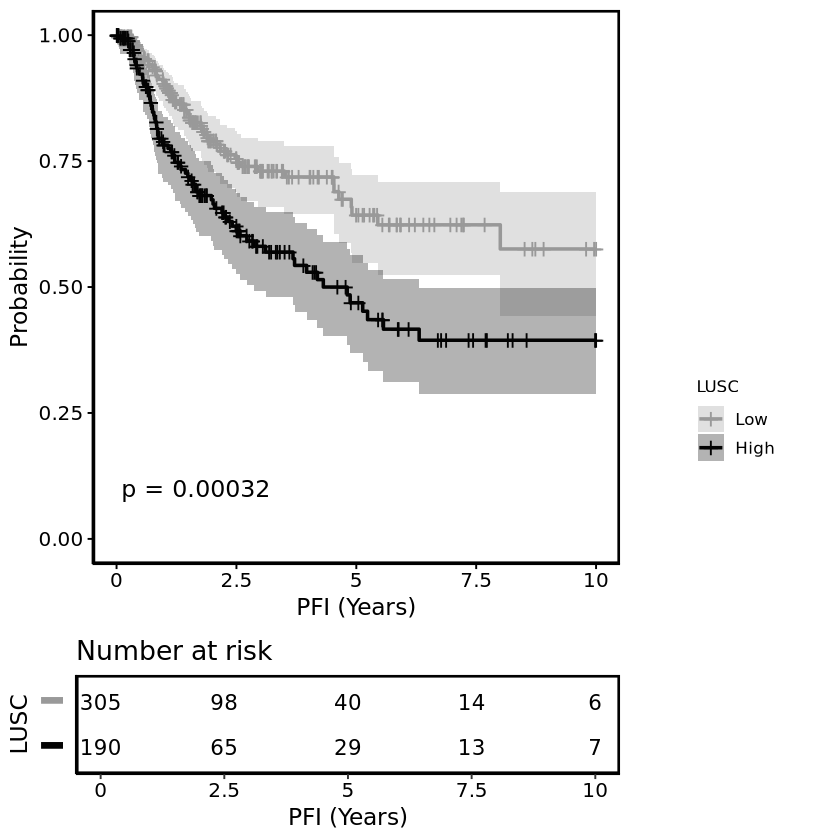

In [41]:
p <- plot_survival(surv.LUSC, column = "LUSC_coxph", legend.title = "LUSC", survival = "PFI", palette = c("grey60", "grey1"), conf.int = T, ylim = c(0, 1), ylab = "Probability", xlab = "PFI (Years)", pval.coord = c(0.1, 0.1))
p

In [42]:
surv <- merge(surv, surv.LUSC[, c("LUSC_coxph"), drop = F], by = 0, all.x = T) %>%
    column_to_rownames("Row.names")

## LUAD
Filter only LUAD patients and repeat with LUSC signatures.

In [43]:
find_coxph_cutoff <- function(df, column, survival, set_cutoff = NULL, covariates = NULL, interquartile = T){

    #split data at 200 intervals and find the cutoff with most significant difference in survival
    if(length(covariates) > 0){
        covariates_coxph <- paste0(" + ", paste0(covariates, collapse = " + "))
        print(paste0("set covariates ===> ", covariates_coxph))}
    else{
	    covariates_coxph <- ""}
    cutoff <- NULL

    if(interquartile){
        lower <- quantile(df[[column]])[[2]]
        upper <- quantile(df[[column]])[[4]]}
    else{
        lower <- min(df[[column]])
	upper <- max(df[[column]])}

    no <- nrow(df)

    for (split in seq(lower, upper, length.out = 200)) {
        df[["coxph"]] <- ifelse(df[[column]] > split, "High", "Low")
        df[["coxph"]] <- factor(df[["coxph"]], levels = c("Low", "High"))
        remove <- any(table(df$coxph) < no / 20)
        if (remove) {
            next
        }
        surv.cox <- coxph(as.formula(paste0(survival, " ~ coxph", covariates_coxph)), data = df)
        
        # Extract HR and p-value
        hr <- round(exp(coef(surv.cox))[1], 3)  # Hazard Ratio
        logr <- round(summary(surv.cox)$coefficients[1, "Pr(>|z|)"], 3)  # p-value
        
        cutoff <- rbind(cutoff, c(split, hr, logr))
        colnames(cutoff) <- c("cutoff", "HR", "logr")
    }


    # use most significant cutoff to split data in "High" & "Low" groups
    cutoff <- as.data.frame(cutoff) %>% arrange(logr)
    if(length(set_cutoff) == 0){
        threshold <- cutoff$cutoff[1]}
    else if(length(set_cutoff) == 1){
        threshold <- set_cutoff}
    else{
	error("set_cutoff should be set to length of 1")}
    print(paste0("for <", column, ">, cutoff is set at  ===> ", threshold))
    df[[paste0(column, "_coxph")]] <- ifelse(df[[column]] > paste0(threshold), "High", "Low")
    df[[paste0(column, "_coxph")]] <- factor(df[[paste0(column, "_coxph")]], levels=c("Low", "High"))
    df$coxph <- NULL
    return(df)
}


In [44]:
surv.LUAD <- surv %>% 
    filter(type == "LUAD")
surv.LUAD <- find_coxph_cutoff(df = surv.LUAD, column = "LUAD", survival = "PFI", covariate = NULL, interquartile = T)

[1] "for <LUAD>, cutoff is set at  ===> 5.2353"


In [45]:
head(surv)

,type,PFI_1,PFI_time_1,PFI_2,PFI_time_2,PFS,PFS_time,DSS_cr,DSS_time_cr,DFI_cr,⋯,PFI_time_cr,PFI_1_cr,PFI_time_1_cr,PFI_2_cr,PFI_time_2_cr,PFI,lung,LUSC,LUAD,LUSC_coxph
,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<Surv>,<dbl>,<dbl>,<dbl>,<fct>
TCGA-05-4249,LUAD,0,4.1697467,0,1523,0,1523,0,1523,NA,⋯,1523,0,1523,0,1523,"4.1697467, 0",7.4015,6.3764,5.0068,NA
TCGA-05-4250,LUAD,0,0.3312799,0,121,1,121,NA,121,NA,⋯,121,2,121,2,121,"0.3312799, 0",8.0044,6.8932,5.9218,NA
TCGA-05-4382,LUAD,1,0.9144422,1,334,1,334,0,607,1,⋯,334,1,334,1,334,"0.9144422, 1",7.6315,6.2107,5.2858,NA
TCGA-05-4384,LUAD,1,0.5010267,1,183,1,183,0,426,NA,⋯,183,1,183,1,183,"0.5010267, 1",8.0361,6.3106,6.1525,NA
TCGA-05-4389,LUAD,0,3.7481177,0,1369,0,1369,0,1369,NA,⋯,1369,0,1369,0,1369,"3.7481177, 0",7.8553,6.4251,5.6181,NA
TCGA-05-4390,LUAD,1,1.0814511,NA,NA,1,395,0,1126,NA,⋯,395,1,395,NA,NA,"1.0814511, 1",8.8213,6.5057,5.7669,NA


In [46]:
plot_survival <- function(df, column, survival, palette = NULL, ...){
    if(!(column %in% colnames(df))){
	message(paste0("<", column, "> not found in dataframe. Skipped"))
	next}

    suppressMessages({
    b <- as.formula(paste0(survival, "~", column))
    fit <- eval(substitute(survfit(b, data = df, conf.type = "log-log"), list(b = b)))

    if(length(names(fit$strata)) > 1){
        names(fit$strata) <- gsub(".*=", "", names(fit$strata))
        kmplot <- ggsurvplot(
            fit,
            data = df,
            palette = palette,
            risk.table = T,
            pval = T,
            risk.table.y.text.col = T,
            risk.table.y.text = F,
            legend = "right",
            ...)
            }
    else{
            kmplot <- NULL
    }})
    kmplot[[1]] <- kmplot[[1]] + theme(panel.border = element_rect(colour = "black", fill=NA, size=1.5))
    kmplot[[2]] <- kmplot[[2]] + theme(panel.border = element_rect(colour = "black", fill=NA, size=1.5))
    return(kmplot)}

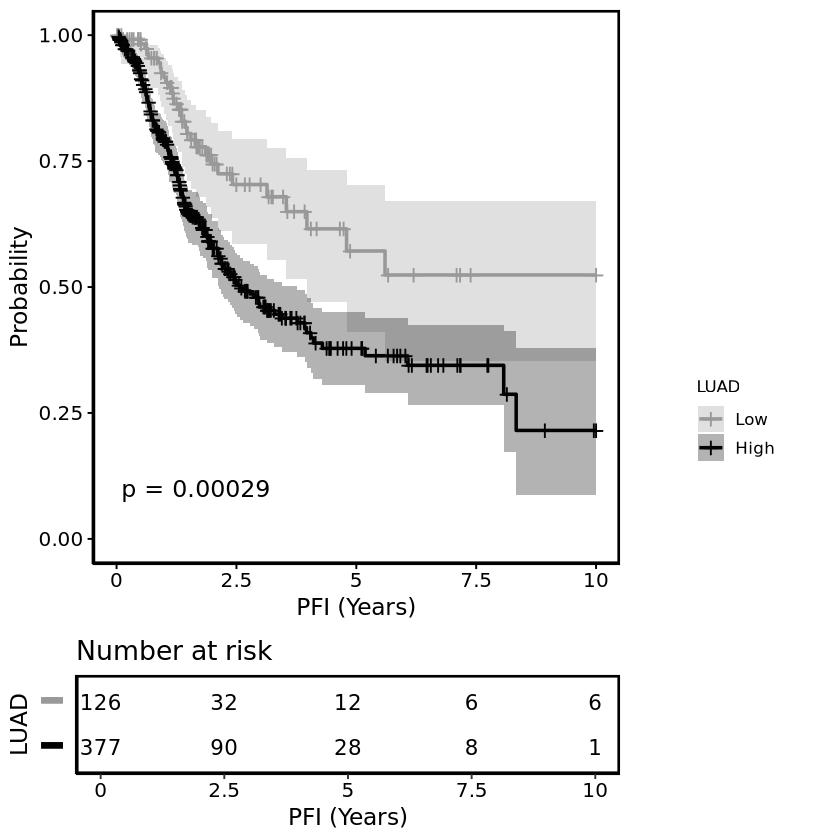

In [47]:
p <- plot_survival(surv.LUAD, column = "LUAD_coxph", legend.title = "LUAD", survival = "PFI", palette = c("grey60", "grey1"), conf.int = T, ylim = c(0, 1), ylab = "Probability", xlab = "PFI (Years)", pval.coord = c(0.1, 0.1))
p

In [24]:
surv <- merge(surv, surv.LUAD[, c("LUAD_coxph"), drop = F], by = 0, all.x = T) %>%
    column_to_rownames("Row.names")

## Save Output

In [33]:
class <- surv[,c("LUSC_coxph", "LUAD_coxph"), drop = F]
for(c in 1:ncol(class)){
    class[,c] <- as.character(class[,c])}
class[class == "High"] <- 1
class[class == "Low"] <- 0
head(class)

write.csv(class, "../3_classification/TCGA_metastatic_classification.csv", quote = F)

,LUSC_coxph,LUAD_coxph
,<chr>,<chr>
TCGA-05-4249,NA,0
TCGA-05-4250,NA,1
TCGA-05-4382,NA,1
TCGA-05-4384,NA,1
TCGA-05-4389,NA,1
TCGA-05-4390,NA,1
